In [1]:
import pandas as pd
import talib
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression

# Create an indicators dataframe

In [2]:
def create_feature_df(df):

	ema30 = pd.Series(talib.EMA(np.array(df['Close']), timeperiod=30), name='EMA30')
	#print ema30

	sma20  = pd.Series(talib.SMA(np.array(df['Close']), timeperiod=20),  name='SMA20')
	sma50  = pd.Series(talib.SMA(np.array(df['Close']), timeperiod=50),  name='SMA50')
	sma200 = pd.Series(talib.SMA(np.array(df['Close']), timeperiod=200), name='SMA200')


	#trading strategies
	upperband, middleband, lowerband = talib.BBANDS(np.array(df['Close']), timeperiod=5, nbdevup=2, nbdevdn=2)

	upperband  = pd.Series(upperband, name='Bollinger5+2')
	middleband = pd.Series(middleband, name='Bollinger5')
	lowerband  = pd.Series(lowerband, name='Bollinger5-2')

	BBand = pd.Series((df['Close'] - middleband)/(2*(upperband-middleband)), name='BBAND')

	macd, macdsignal, macdhist = talib.MACD(np.array(df['Close']), fastperiod=12, slowperiod=26, signalperiod=9)

	macd       = pd.Series(macd, name='MACD')
	macdsignal = pd.Series(macdsignal, name='MACD_Signal')
	macdhist   = pd.Series(macdhist, name='MACD_Hist')

	obv = pd.Series(talib.OBV(np.array(df['Close']), np.array(df['Volume'].astype(float))), name='OBV').astype(int)
	mfi = pd.Series(talib.MFI(np.array(df['High']), np.array(df['Low']), np.array(df['Close']), np.array(df['Volume'].astype(float)), timeperiod=14), name='MFI')
	rsi = pd.Series(talib.RSI(np.array(df['Close']), timeperiod=14), name='RSI')
	adx = pd.Series(talib.ADX(np.array(df['High']), np.array(df['Low']), np.array(df['Close']), timeperiod=14), name='ADX')
	wpr = pd.Series(talib.WILLR(np.array(df['High']), np.array(df['Low']), np.array(df['Close']), timeperiod=14), name='WILLR')

	daily = pd.Series(df['Close'].pct_change(1), name='DAILY_RETURN')
	oc_pct = pd.Series(((df['Open']+df['Close'])/2).pct_change(1), name='OC_DAILY_RETURN')
	df = df.join([sma20, sma50, sma200, BBand, macd, macdsignal, macdhist, obv, mfi, rsi, adx, wpr, daily, oc_pct])

	return df

In [3]:
#def run_regression(df):
#def run_random_forest(df):
#def run_decision_tree(df):
#	

In [4]:
#Read the dataframe
df = pd.read_csv('../data/NSE/Cap-Size/SUPREMEIND.NS.csv')
df = create_feature_df(df)
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.dropna()
#print df['OBV']
#print(df.corr())
#result = seasonal_decompose(df['OBV'], model='additive', freq=252)
#result.plot()
#df['Close'].plot()
#plt.show()
#df.to_csv('ml.csv')

### Create Long & Short orders based on Local Maxima/Minima of Close

In [5]:
prices = list(df['Close'])
dates = list(df.index)

long_orders = []
i = 0
while i < len(prices)-1:
	while i < len(prices)-1 and prices[i+1] <= prices[i]:
		i = i + 1
	if i == len(prices)-1:
		break
	buy_on = dates[i]
	buy_at = prices[i]
	i = i + 1
	while i < len(prices)-1 and prices[i-1] <= prices[i]:
		i = i + 1
	order = ({	'Buy_On'  : buy_on,
				'Buy_At'  : buy_at,
				'Sell_On' : dates[i-1],
			  	'Sell_At' : prices[i-1],
			  	'Profit'  : prices[i-1] - buy_at})
	long_orders.append(order)

short_orders = []
i = 1
while i < len(prices)-1:
	while i < len(prices)-1 and prices[i] <= prices[i+1]:
		i = i + 1
	if i == len(prices)-1:
		break
	short_on = dates[i]
	short_at = prices[i]
	i = i + 1
	while i < len(prices)-1 and prices[i-1] >= prices[i]:
		i = i + 1
	order = ({	'Buy_On'   : dates[i-1],
				'Buy_At'   : prices[i-1],
				'Short_On' : short_on,
			  	'Short_At' : short_at,
			  	'Profit'   : short_at - prices[i-1]})
	short_orders.append(order)

## Shortlist orders
#### If 'Invested' amount and sought 'Profit'

In [6]:
Invested = 10000
Profit = 500

long_orders  = [order for order in long_orders  if (math.ceil(Invested/order['Buy_At'] * order['Profit']) >= Profit)]
#for i in range(0, len(long_orders)):
#	print(long_orders[i])

short_orders = [order for order in short_orders if (math.ceil(Invested/order['Buy_At'] * order['Profit']) >= Profit)]


Orders_DF = pd.DataFrame(index=dates, columns=['Long', 'Short'])

for i in range(0, len(long_orders)):
	Orders_DF.set_value(long_orders[i]['Buy_On'], 'Long', -1)
	Orders_DF.set_value(long_orders[i]['Sell_On'], 'Long', +1)

for i in range(0, len(short_orders)):
	Orders_DF.set_value(short_orders[i]['Buy_On'], 'Short', -1)
	Orders_DF.set_value(short_orders[i]['Short_On'], 'Short', +1)

Orders_DF = Orders_DF.fillna(0)

In [7]:
#Add Signal to that dataframe [-1 : Buy ; +1 : Sell ; 0 : Do Nothing]
df['Long_Signal']  = Orders_DF['Long']
df['Short_Signal'] = Orders_DF['Short']

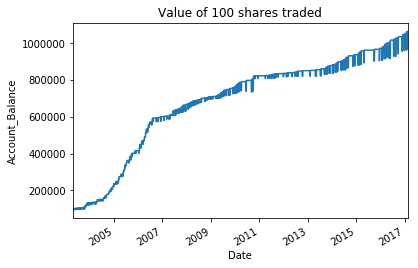

In [8]:
initial_trading_capital = 100000
trading_capital = initial_trading_capital

shares_traded = 100   #trading_capital/price_on_that_day

#Value of |shares_bought| if bought according to Long_Signal
df['Long_Value']  = df.Close * shares_traded * df.Long_Signal
df['Short_Value'] = df.Close * shares_traded * df.Short_Signal


#print test_df.Long_Value.sum(axis=0)
#print test_df.Short_Value.sum(axis=0)


long_value = list(df.Long_Value)
capital = [None] * len(long_value)

for i in range(0, len(long_value)):
    trading_capital += long_value[i]
    capital[i] = trading_capital

df['Capital'] = capital

test_df = df.tail(66)
df.Capital.plot(kind='line')
plt.ylabel('Account_Balance')
plt.title('Value of 100 shares traded')
plt.show()

In [9]:
#Create the dataset
df = df.dropna()
X = df[['Close', 'Volume', 'SMA20', 'SMA50', 'SMA200', 'BBAND', 'MACD', 'MACD_Signal', 'OBV', 'MFI', 'RSI', 'ADX', 'WILLR']]
y = df['Long_Signal']

            index     Open     High     Low    Close  Volume  Adj Close  \
Date                                                                      
2003-04-23    199    40.03    40.03   40.03    40.03    1000      0.022   
2003-04-24    200    39.30    41.00   39.30    40.95    1100      0.022   
2003-04-25    201    41.90    41.90   41.90    41.90    1000      0.023   
2003-04-28    202    39.70    40.55   39.05    39.05    2500      0.021   
2003-04-29    203    39.15    39.50   39.00    39.18   43500      0.021   
2003-04-30    204    39.50    39.50   39.13    39.13    2300      0.021   
2003-05-02    205    39.00    40.98   39.00    40.93    6100      0.022   
2003-05-05    206    40.50    41.98   40.50    41.78  104200      0.023   
2003-05-06    207    42.00    42.23   41.73    42.23    4500      0.023   
2003-05-07    208    41.55    43.38   41.55    42.80   15600      0.023   
2003-05-08    209    42.15    44.33   42.15    43.50   10000      0.024   
2003-05-09    210    43.5

#### Split the dataset - training / test - 80/20

In [10]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
total_size = len(X)
train_size = int(math.floor(0.8*total_size)) #(80% part of my dataset)

#training dataset
X_train = X.head(train_size)
y_train = y.head(train_size)

#test dataset
X_test = X.tail(len(X) - train_size)
y_test = y.tail(len(y) - train_size)

In [13]:
#rf_model = RandomForestClassifier(n_estimators=500, max_features=4, oob_score=True)
# Train the model using the training sets and check score

#rf_model.fit(X_train, y_train)
#X_train = X_train.dropna()
#y_train = y_train.dropna()
#rf_predictions = rf_model.predict(X_test)
print X_train, y_train
lr = LogisticRegression()
lr.fit(X_train.values, y_train.values)
lr_predictions = lr.predict(X_test.values)
print lr_predictions
#X_test['prediction_signal'] = pd.Series(predictions).values
print X_test
#plt.plot()
#plt.show()

#for i in range(0, len(short_orders)):
#	print(short_orders[i])

#add market index
#add_index_Close()

             Close  Volume     SMA20      SMA50      SMA200     BBAND  \
Date                                                                    
2003-04-23   40.03    1000   40.0440   42.44556   39.360780  0.040691   
2003-04-24   40.95    1100   40.0400   42.22756   39.542090  0.387408   
2003-04-25   41.90    1000   40.1475   41.99096   39.726840  0.391207   
2003-04-28   39.05    2500   40.1335   41.72136   39.897190 -0.353366   
2003-04-29   39.18   43500   40.0425   41.50096   40.067865 -0.241000   
2003-04-30   39.13    2300   40.0215   41.31356   40.238765 -0.195000   
2003-05-02   40.93    6100   40.1180   41.15416   40.417465  0.191228   
2003-05-05   41.78  104200   40.2820   41.06176   40.600465  0.391333   
2003-05-06   42.23    4500   40.4360   40.97176   40.786640  0.306156   
2003-05-07   42.80   15600   40.4985   40.89476   40.976140  0.278998   
2003-05-08   43.50   10000   40.5995   40.81476   41.168640  0.357688   
2003-05-09   44.83   39000   40.8520   40.77676   4

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').